***BÀI TOÁN NER***

In [1]:
!pip install --upgrade --force-reinstall numpy==1.26.4 scikit-learn==1.2.2 joblib==1.2.0
!pip install -q sklearn-crfsuite seqeval transformers matplotlib seaborn tqdm tabulate

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scikit_learn-1.2.2-cp312-cp312-linux_x86_64.whl
  Using cached joblib-1.2.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached scipy-1.16.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
Using cached scipy-1.16.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (35.7 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Succ

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

2025-12-20 08:38:25.113850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766219905.296849     784 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766219905.351828     784 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766219905.785916     784 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766219905.785959     784 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766219905.785962     784 computation_placer.cc:177] computation placer alr

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Vectorizing:   0%|          | 0/382 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

PhoBERT Evaluating:   0%|          | 0/382 [00:00<?, ?it/s]


 BẢNG TỔNG HỢP
 +---------+--------------------+--------------------+---------------------+
|  Model  |      Accuracy      |       Recall       |      F1-Entity      |
+---------+--------------------+--------------------+---------------------+
| LogReg  | 0.8164023530221198 | 0.8164023530221198 | 0.45934815860689493 |
|   SVM   | 0.8167807630121435 | 0.8167807630121435 | 0.4851461427886919  |
|   CRF   | 0.8165055557466717 | 0.8165055557466717 |  0.628300803673938  |
| PhoBERT | 0.8472599676631463 | 0.8472599676631463 | 0.6405245240196695  |
+---------+--------------------+--------------------+---------------------+


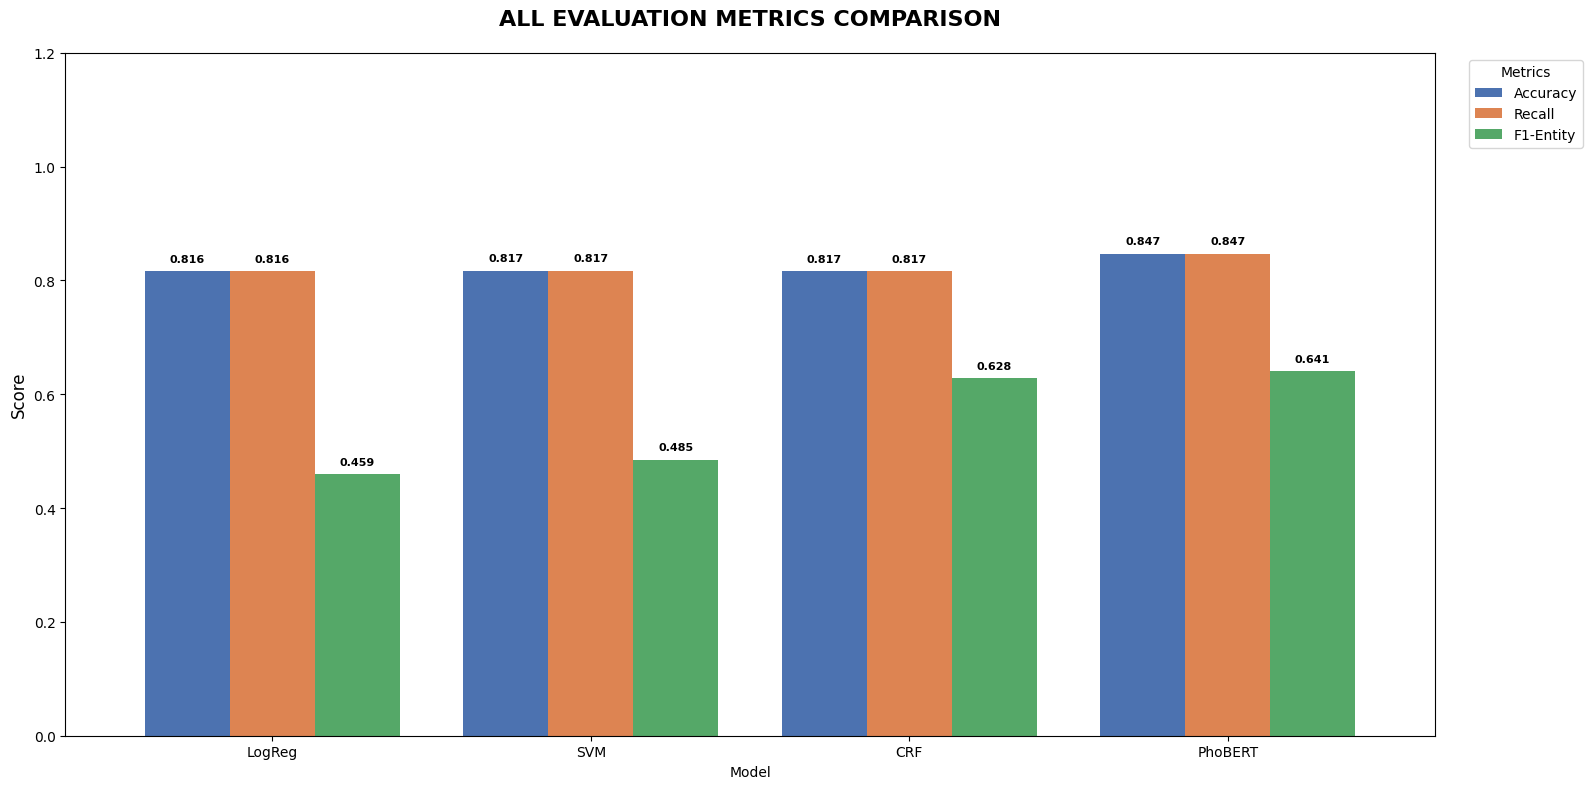

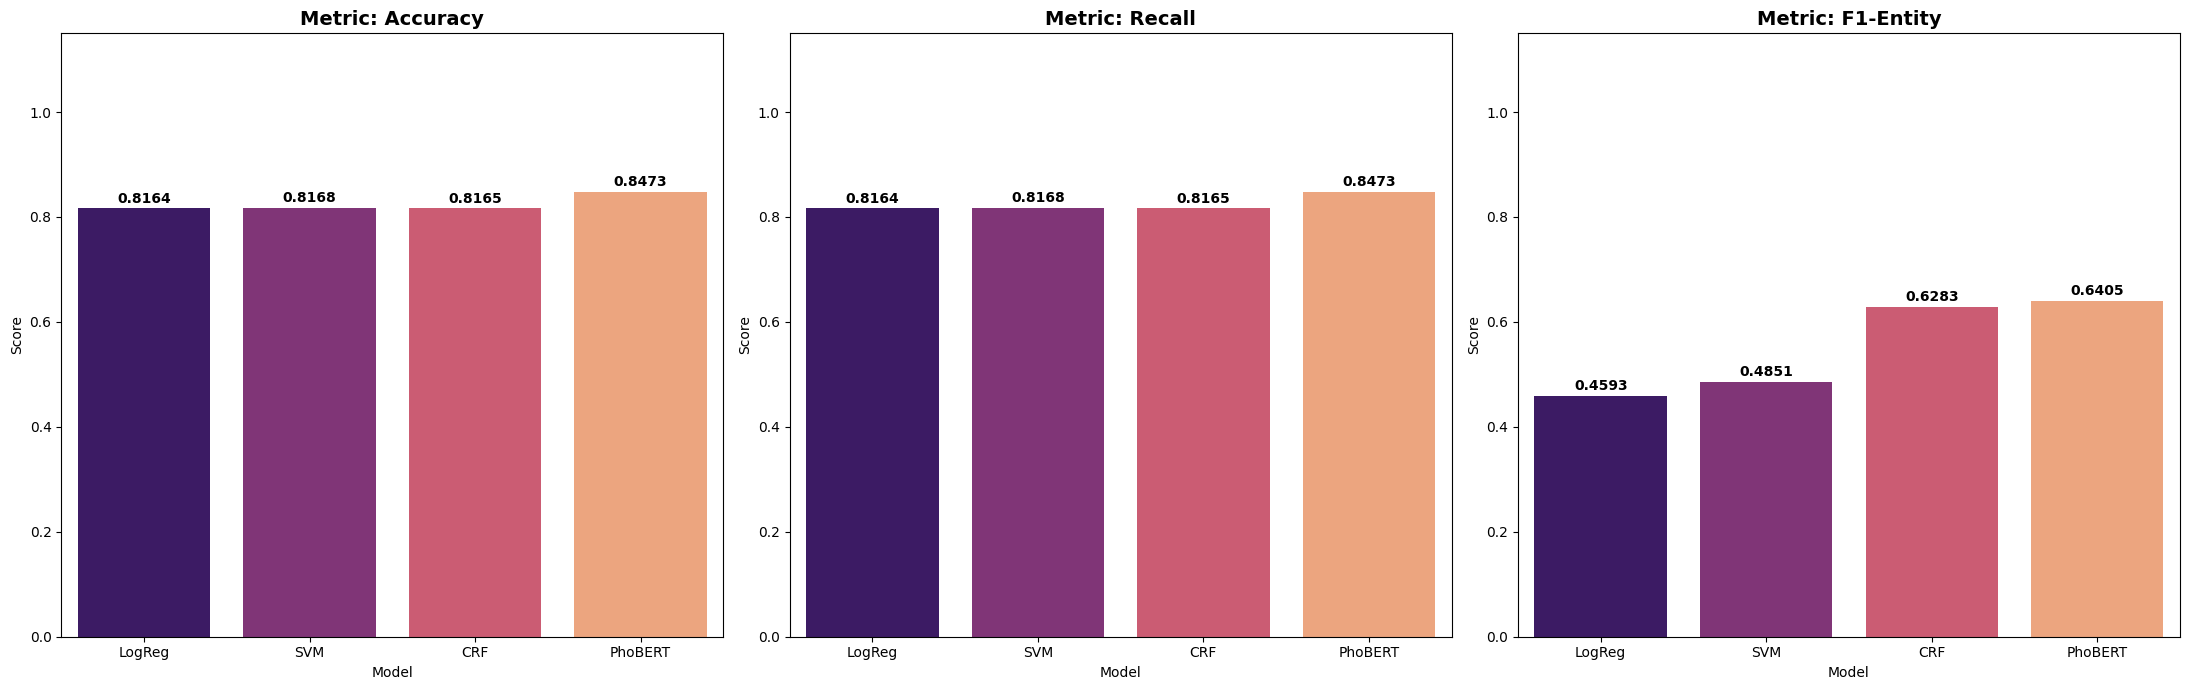

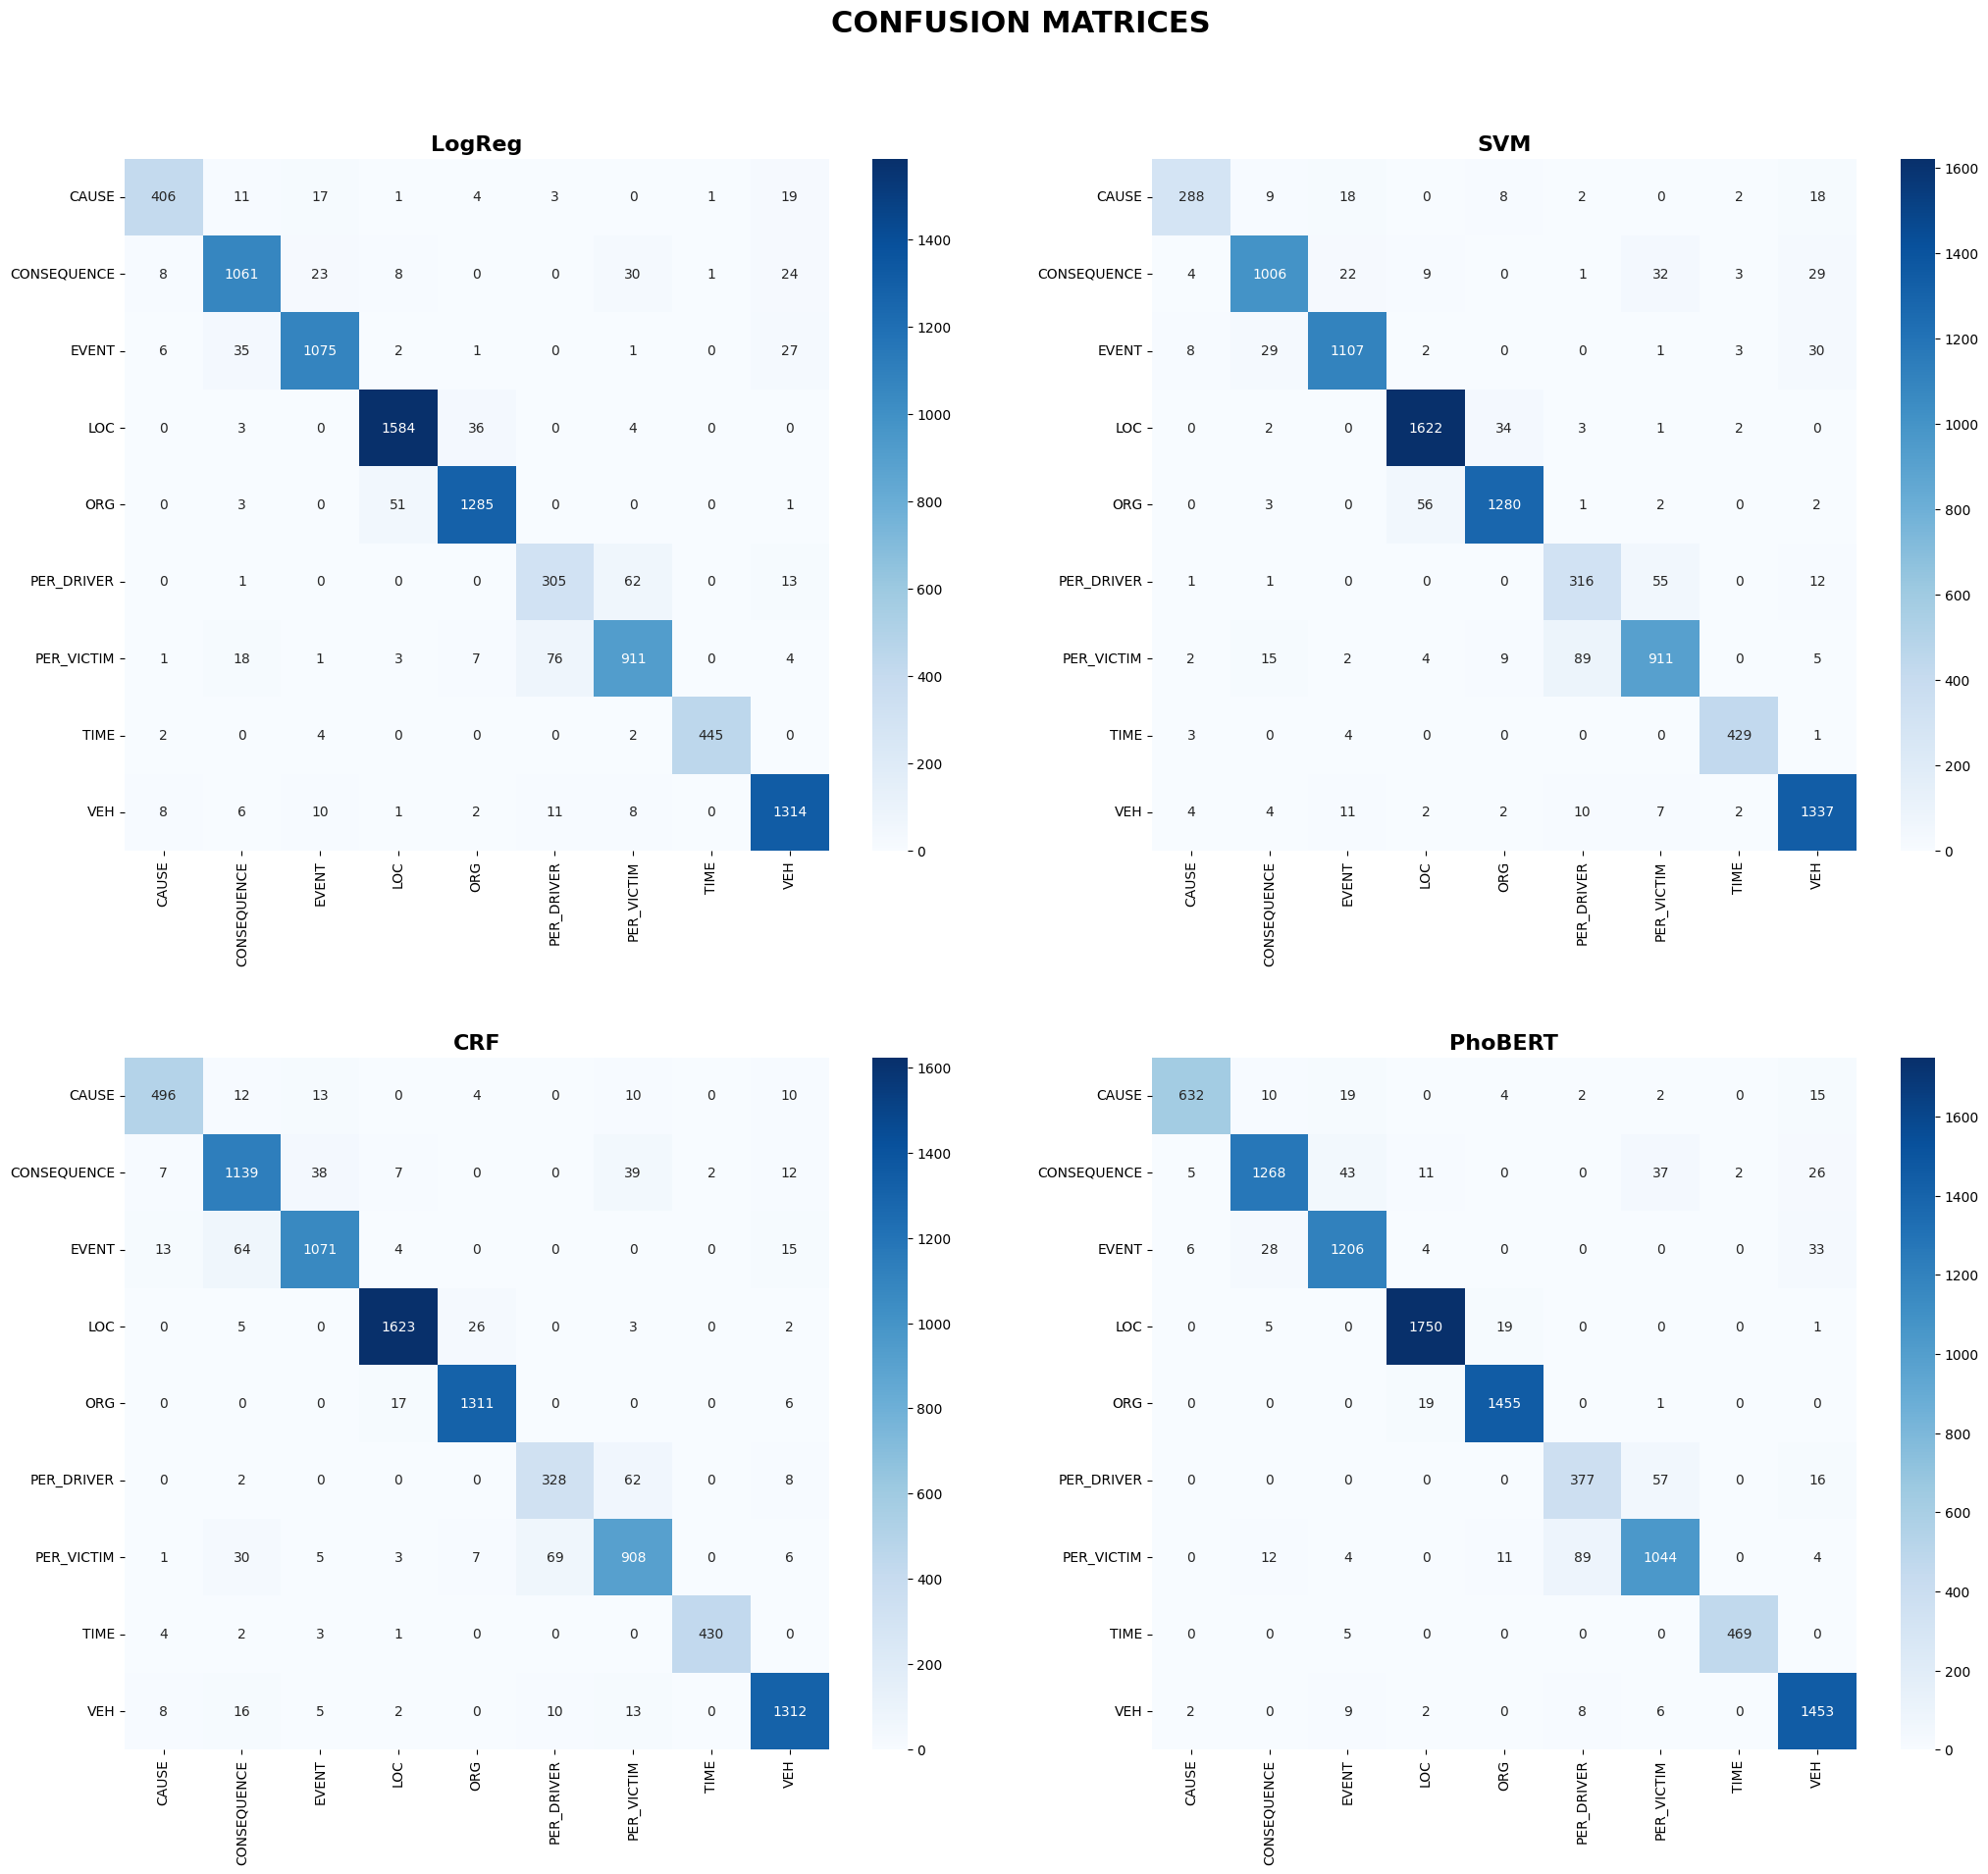

In [2]:
import os, json, random, joblib, torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel, AutoModelForTokenClassification
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from seqeval.metrics import f1_score as seq_f1 

# Cấu hình hệ thống
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed=42):
    random.seed(seed); os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed(seed); torch.cuda.manual_seed_all(seed)

seed_everything(42)

label_list = ["O", "B-LOC", "I-LOC", "B-VEH", "I-VEH", "B-EVENT", "I-EVENT",
              "B-PER_DRIVER", "I-PER_DRIVER", "B-PER_VICTIM", "I-PER_VICTIM",
              "B-ORG", "I-ORG", "B-CONSEQUENCE", "I-CONSEQUENCE", "B-TIME", "I-TIME", "B-CAUSE", "I-CAUSE"]
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for i, l in enumerate(label_list)}
n_classes = len(label_list)

# Hàm xử lí đặc trưng

def convert_data_label_studio_to_bio(json_path):
    """Bóc tách dữ liệu từ JSON Label Studio sang BIO format"""
    if not os.path.exists(json_path): return []
    with open(json_path, 'r', encoding='utf-8') as f: data = json.load(f)
    processed_data = []
    
    for item in data:
        if 'data' not in item or 'text' not in item['data']: continue
        raw_text = item['data']['text']
        words = raw_text.split() 
        labels = ["O"] * len(words)
        word_spans, current_char = [], 0
        for w in words:
            start = raw_text.find(w, current_char)
            end = start + len(w)
            word_spans.append((start, end))
            current_char = end
        if 'annotations' in item:
            for annotation in item['annotations']:
                for result in annotation['result']:
                    if result['type'] == 'labels':
                        label_type = result['value']['labels'][0]
                        if label_type in ["Cause", "CAUSES"]: label_type = "CAUSE"
                        start_char, end_char = result['value']['start'], result['value']['end']
                        start_token_idx, end_token_idx = -1, -1
                        for idx, (w_start, w_end) in enumerate(word_spans):
                            if max(w_start, start_char) < min(w_end, end_char):
                                if start_token_idx == -1: start_token_idx = idx
                                end_token_idx = idx
                        if start_token_idx != -1:
                            b_label, i_label = f"B-{label_type}", f"I-{label_type}"
                            if b_label in label_list:
                                labels[start_token_idx] = b_label
                                for k in range(start_token_idx + 1, end_token_idx + 1): labels[k] = i_label
        if len(words) > 0:
            processed_data.append({"tokens": words, "ner_tags": [label2id[l] for l in labels], "ner_tags_str": labels})
    return processed_data

def clean_labels_for_cm(label_ids):
    """Gộp nhãn B- và I- thành nhãn chung cho Confusion Matrix"""
    return [id2label[lid].split('-')[1] if '-' in id2label[lid] else id2label[lid] for lid in label_ids]

def extract_features(dataset):
    """Trích xuất embeddings từ PhoBERT Base"""
    X_flat, y_flat, X_seq, y_seq = [], [], [], []
    tk = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
    md = AutoModel.from_pretrained("vinai/phobert-base").to(DEVICE)
    for item in tqdm(dataset, desc="Vectorizing"):
        tkns, tags, tags_str = item['tokens'], item['ner_tags'], item['ner_tags_str']
        ins = tk(tkns, is_split_into_words=True, return_tensors="pt", padding=True, truncation=True, max_length=256).to(DEVICE)
        with torch.no_grad(): 
            outs = md(**ins); embs = outs.last_hidden_state[0].cpu().numpy()
        wids = [None]
        for i, w in enumerate(tkns):
            wids.extend([i] * len(tk.encode(w, add_special_tokens=False)))
        wids = (wids + [None])[:ins['input_ids'].shape[1]]
        sent_feats, sent_labels, seen = [], [], set()
        for idx, wid in enumerate(wids):
            if wid is not None and wid < len(tags) and wid not in seen and idx < len(embs):
                X_flat.append(embs[idx]); y_flat.append(tags[wid])
                sent_feats.append({f'd{i}': v for i, v in enumerate(embs[idx])})
                sent_labels.append(tags_str[wid]); seen.add(wid)
        if sent_feats: X_seq.append(sent_feats); y_seq.append(sent_labels)
    del md; torch.cuda.empty_cache()
    return np.array(X_flat), np.array(y_flat), X_seq, y_seq

def flat_to_seq(y_flat, y_seq_struct):
    y_seq, cursor = [], 0
    for sent in y_seq_struct:
        slc = y_flat[cursor:cursor+len(sent)]
        y_seq.append([id2label[i] if isinstance(i, (int, np.integer)) else i for i in slc])
        cursor += len(sent)
    return y_seq

# Chương trình chính
if __name__ == "__main__":
    DATA_PATH = "/kaggle/input/vietnamese-traffic-accident-ner-dataset/output.json"
    MODEL_DIR = "/kaggle/input/vn-traffic-ner-models"
    
    raw_data = convert_data_label_studio_to_bio(DATA_PATH)
    train_data, temp_data = train_test_split(raw_data, test_size=0.3, random_state=42)
    _, te = train_test_split(temp_data, test_size=0.77, random_state=42)
    
    X_ml, y_ml, X_crf, y_crf = extract_features(te)
    results_list, preds_cm = [], {}

    # Đánh giá LogReg, SVM, CRF
    configs = [('LogReg', 'logistic_regression.pkl'), ('SVM', 'svm_model.pkl'), ('CRF', 'crf_model.pkl')]
    for name, filename in configs:
        p = os.path.join(MODEL_DIR, filename)
        if os.path.exists(p):
            m = joblib.load(p)
            yp = m.predict(X_ml) if name != 'CRF' else [label2id[t] for s in m.predict(X_crf) for t in s]
            yt = y_ml if name != 'CRF' else [label2id[l] for s in y_crf for l in s]
            preds_cm[name] = (yt, yp)
            results_list.append({
                "Model": name, 
                "Accuracy": accuracy_score(yt, yp),
                "Recall": recall_score(yt, yp, average='weighted'),
                "F1-Entity": seq_f1(y_crf, flat_to_seq(yp, y_crf), mode='strict')
            })

    # Đánh giá PhoBERT Fine-tuned
    p_ft = os.path.join(MODEL_DIR, "phobert_finetuned")
    if os.path.exists(p_ft):
        tk = AutoTokenizer.from_pretrained(p_ft, use_fast=False)
        ft_m = AutoModelForTokenClassification.from_pretrained(p_ft).to(DEVICE).eval()
        yt_all, yp_all, yt_s, yp_s = [], [], [], []
        for item in tqdm(te, desc="PhoBERT Evaluating"):
            ins = tk(item['tokens'], is_split_into_words=True, return_tensors="pt", padding=True, truncation=True, max_length=256).to(DEVICE)
            with torch.no_grad(): 
                outs = ft_m(**ins); preds = torch.argmax(outs.logits, dim=2)[0].cpu().numpy()
            wids = [None]
            for i, w in enumerate(item['tokens']):
                wids.extend([i] * len(tk.encode(w, add_special_tokens=False)))
            wids = (wids + [None])[:ins['input_ids'].shape[1]]
            seen, cur_p, cur_t = set(), [], []
            for idx, wid in enumerate(wids):
                if wid is not None and wid < len(item['ner_tags']) and wid not in seen and idx < len(preds):
                    yt_all.append(item['ner_tags'][wid]); yp_all.append(preds[idx])
                    cur_p.append(id2label[preds[idx]]); cur_t.append(item['ner_tags_str'][wid]); seen.add(wid)
            if cur_t: yt_s.append(cur_t); yp_s.append(cur_p)
        preds_cm['PhoBERT'] = (yt_all, yp_all)
        results_list.append({
            "Model": "PhoBERT", "Accuracy": accuracy_score(yt_all, yp_all),
            "Recall": recall_score(yt_all, yp_all, average='weighted'),
            "F1-Entity": seq_f1(yt_s, yp_s, mode='strict')
        })

#  Trực quan hóa
    eval_df = pd.DataFrame(results_list).set_index("Model")
    print("\n BẢNG TỔNG HỢP\n", tabulate(eval_df, headers='keys', tablefmt='pretty', floatfmt=".4f"))

    # 4.1 Biểu đồ tổng hợp
    custom_colors = ['#4C72B0', '#DD8452', '#55A868']
    ax = eval_df.plot(kind='bar', figsize=(16, 8), rot=0, width=0.8, color=custom_colors)
    plt.title("ALL EVALUATION METRICS COMPARISON", fontsize=16, fontweight='bold', pad=20)
    plt.ylabel("Score", fontsize=12); plt.ylim(0, 1.2); plt.legend(title="Metrics", bbox_to_anchor=(1.02, 1), loc='upper left')
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=8, fontweight='bold')
    plt.tight_layout(); plt.show()

    # 4.2 Biểu đồ riêng từng chỉ số
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 7))
    axes = axes.flatten()
    for i, metric in enumerate(eval_df.columns):
        sns.barplot(x=eval_df.index, y=eval_df[metric], ax=axes[i], palette='magma', hue=eval_df.index, legend=False)
        axes[i].set_title(f"Metric: {metric}", fontsize=14, fontweight='bold')
        axes[i].set_ylim(0, 1.15); axes[i].set_ylabel("Score")
        for p in axes[i].patches:
            if p.get_height() > 0:
                axes[i].annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                                 ha='center', va='center', xytext=(0, 7), textcoords='offset points', fontsize=10, fontweight='bold')
    plt.tight_layout(); plt.show()

    # Confusion Matrix
    fig, axes = plt.subplots(2, 2, figsize=(22, 20))
    axes = axes.flatten()
    for i, (name, (yt, yp)) in enumerate(preds_cm.items()):
        yt_c, yp_c = clean_labels_for_cm(yt), clean_labels_for_cm(yp)
        lbls = sorted(list(set(yt_c) | set(yp_c)))
        if 'O' in lbls: lbls.remove('O')
        sns.heatmap(confusion_matrix(yt_c, yp_c, labels=lbls), 
                    annot=True, fmt='d', cmap='Blues', xticklabels=lbls, yticklabels=lbls, ax=axes[i], cbar=True)
        axes[i].set_title(f"{name}", fontweight='bold', fontsize=16)
        axes[i].set_xticklabels(lbls, rotation=90, ha='center', fontsize=10)
        axes[i].set_yticklabels(lbls, rotation=0, fontsize=10)
    plt.suptitle("CONFUSION MATRICES", fontsize=22, fontweight='bold', y=0.98)
    plt.tight_layout(pad=5.0); plt.show()

**BÀI TOÁN RE**

In [3]:
!pip install -q pyvi 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 76.6 MB/s eta 0:00:00:00:0100:01


In [4]:
import os, json, joblib, random, itertools, torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyvi import ViTokenizer
from tabulate import tabulate
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
from joblib import Parallel, delayed

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Môi trường sẵn sàng")

# Đường dẫn
DATA_PATH = '/kaggle/input/vietnamese-traffic-accident-ner-dataset/output.json' 
MODEL_DIR = "/kaggle/input/final-models-v3" 

VALID_SCHEMA = {
    'LOCATED_AT': [('EVENT', 'LOC')],
    'HAPPENED_ON': [('EVENT', 'TIME')],
    'INVOLVED': [('EVENT', 'VEH'), ('PER_DRIVER', 'VEH'), ('PER_VICTIM', 'VEH')],
    'CAUSED_BY': [('EVENT', 'CAUSE')],
    'HAS_CONSEQUENCE': [('EVENT', 'CONSEQUENCE')]
}

class BiLSTM(nn.Module):
    def __init__(self, n_vocab, n_class):
        super().__init__()
        self.emb = nn.Embedding(n_vocab, 64, padding_idx=0)
        self.lstm = nn.LSTM(64, 64, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128, n_class)
    def forward(self, x):
        _, (h, _) = self.lstm(self.emb(x))
        return self.fc(torch.cat((h[-2], h[-1]), dim=1))

class LSTMDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=100):
        self.texts, self.labels, self.vocab, self.max_len = texts, labels, vocab, max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        toks = str(self.texts[idx]).split()
        ids = [self.vocab.get(t, 1) for t in toks][:self.max_len]
        ids += [0]*(self.max_len - len(ids))
        return torch.tensor(ids), torch.tensor(self.labels[idx])

Môi trường sẵn sàng


In [5]:

with open(DATA_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

samples = []
for task in data:
    # Lấy text và kiểm tra tính hợp lệ của annotation
    data_obj = task.get('data', {}) or {}
    text = data_obj.get('text') or task.get('text')
    if not text or not task.get('annotations'):
        continue

    res = task['annotations'][0].get('result', [])
    ents, rels = {}, {}

    # Phân loại thực thể và quan hệ
    for item in res:
        if item.get('type') == 'labels' and 'id' in item and 'value' in item:
            v = item['value']
            if 'labels' in v:
                ents[item['id']] = {
                    'l': v['labels'][0], 
                    's': v.get('start', 0), 
                    'e': v.get('end', 0)
                }
        elif item.get('type') == 'relation':
            fid, tid, lbls = item.get('from_id'), item.get('to_id'), item.get('labels', [])
            if fid and tid and lbls:
                rels[(fid, tid)] = lbls[0]

    # Thực hiện hoán vị tất cả các cặp thực thể
    e_ids = list(ents.keys())
    if len(e_ids) < 2:
        continue

    for e1_id, e2_id in itertools.permutations(e_ids, 2):
        e1, e2 = ents[e1_id], ents[e2_id]
        label = rels.get((e1_id, e2_id), "NO_RELATION")
        
        # Kiểm tra tính hợp lệ theo VALID_SCHEMA
        if label != "NO_RELATION":
            if label not in VALID_SCHEMA or (e1['l'], e2['l']) not in VALID_SCHEMA[label]:
                continue
        
        samples.append({
            'text': text, 
            'relation': label, 
            'e1_type': e1['l'], 'e1_start': e1['s'], 'e1_end': e1['e'],
            'e2_type': e2['l'], 'e2_start': e2['s'], 'e2_end': e2['e']
        })

df = pd.DataFrame(samples)


# Tokenize
def process_single_row(row):
    """Chèn Entity Markers và Tokenize văn bản"""
    t = row['text']
    markers = [
        (int(row['e1_start']), " [E1] "), 
        (int(row['e1_end']), " [/E1] "), 
        (int(row['e2_start']), " [E2] "), 
        (int(row['e2_end']), " [/E2] ")
    ]
    markers.sort(key=lambda x: x[0], reverse=True)
    
    for idx, token in markers:
        t = t[:idx] + token + t[idx:]
    
    return ViTokenizer.tokenize(t)

df['processed_text'] = Parallel(n_jobs=-1)(
    delayed(process_single_row)(row) for _, row in df.iterrows()
)


# Split dữ liệu
meta = joblib.load(os.path.join(MODEL_DIR, "metadata.pkl"))
label2id, vocab = meta["label2id"], meta["lstm_vocab"]
_, test_df = train_test_split(df, test_size=0.2, random_state=42)
y_test = [label2id.get(l, 0) for l in test_df['relation']]

print(f"Xử lý hoàn tất tập Test với {len(test_df)} mẫu.")

Xử lý hoàn tất tập Test với 42694 mẫu.


+---------+--------------------+--------------------+---------------------+--------------------+
|  Model  |      Accuracy      |       Recall       |      F1-Macro       |      F1-Micro      |
+---------+--------------------+--------------------+---------------------+--------------------+
|   SVM   | 0.9647491450789338 | 0.9647491450789338 | 0.23104415842028322 | 0.9647491450789338 |
|   RF    | 0.964491497634328  | 0.964491497634328  | 0.1977408972481316  | 0.964491497634328  |
|   LR    | 0.9651473274933245 | 0.9651473274933245 | 0.22773121497240265 | 0.9651473274933245 |
| Bi-LSTM | 0.9790134445121095 | 0.9790134445121095 | 0.6802936282905386  | 0.9790134445121095 |
+---------+--------------------+--------------------+---------------------+--------------------+


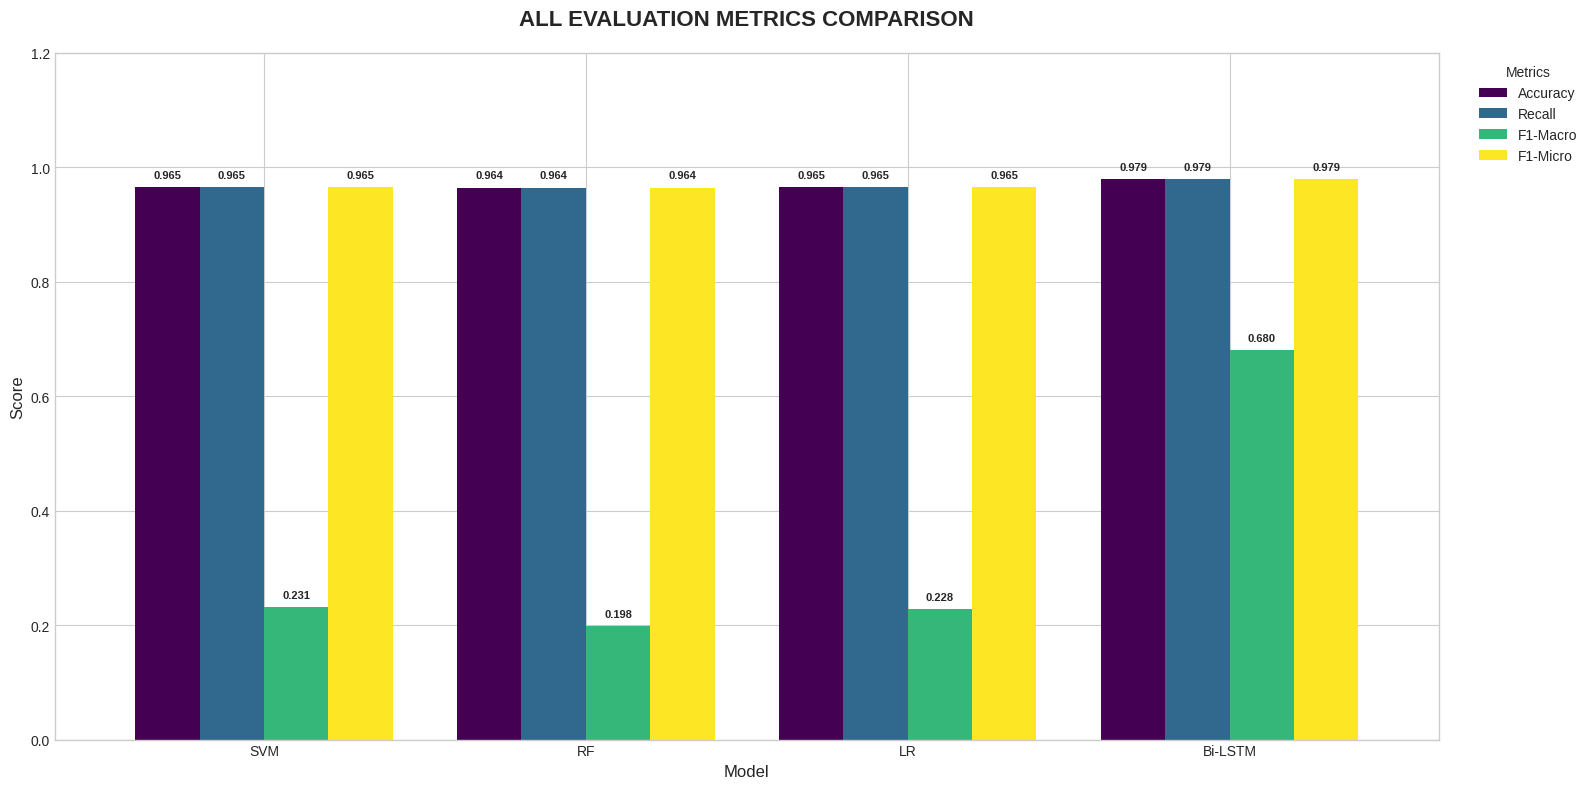

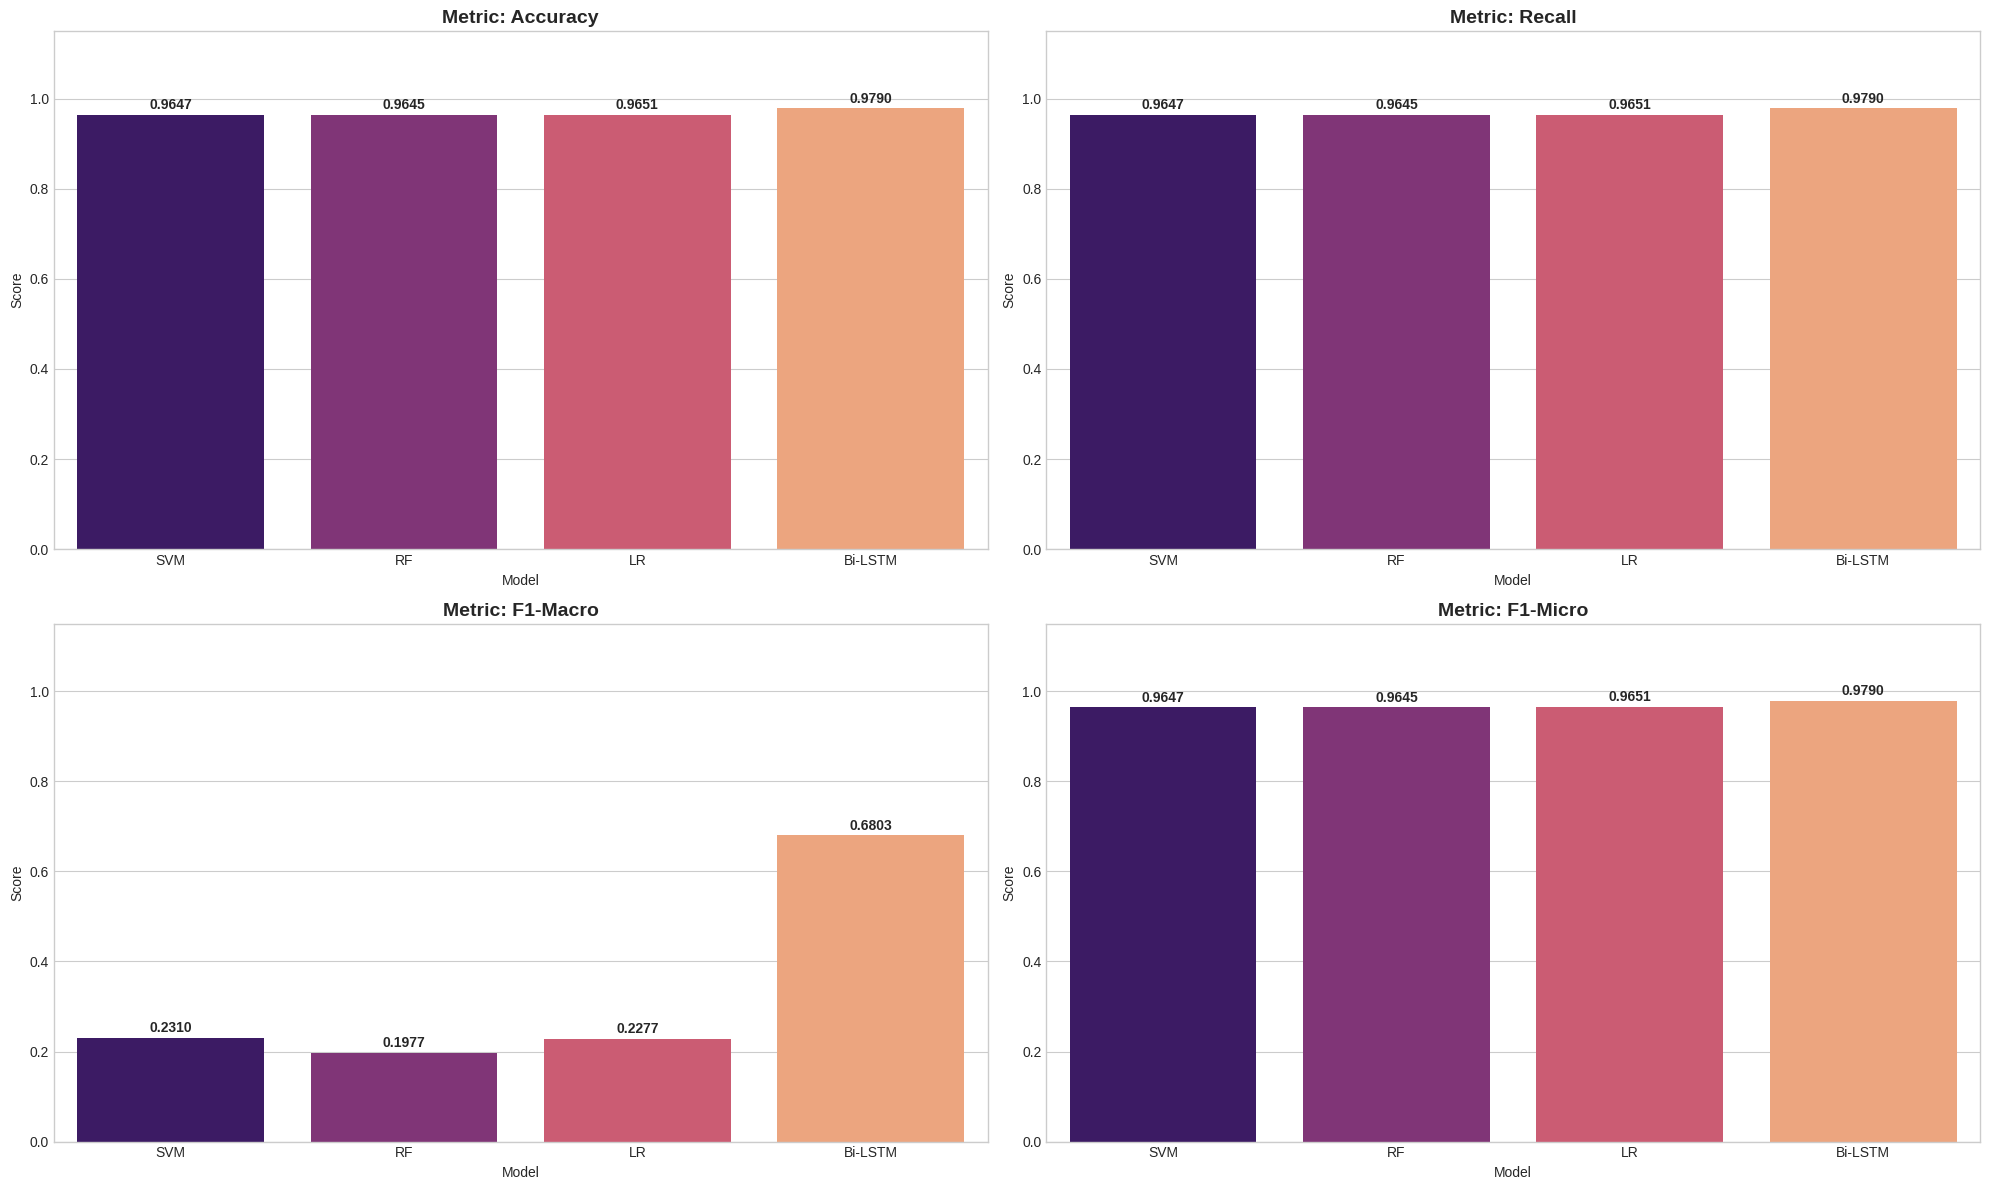

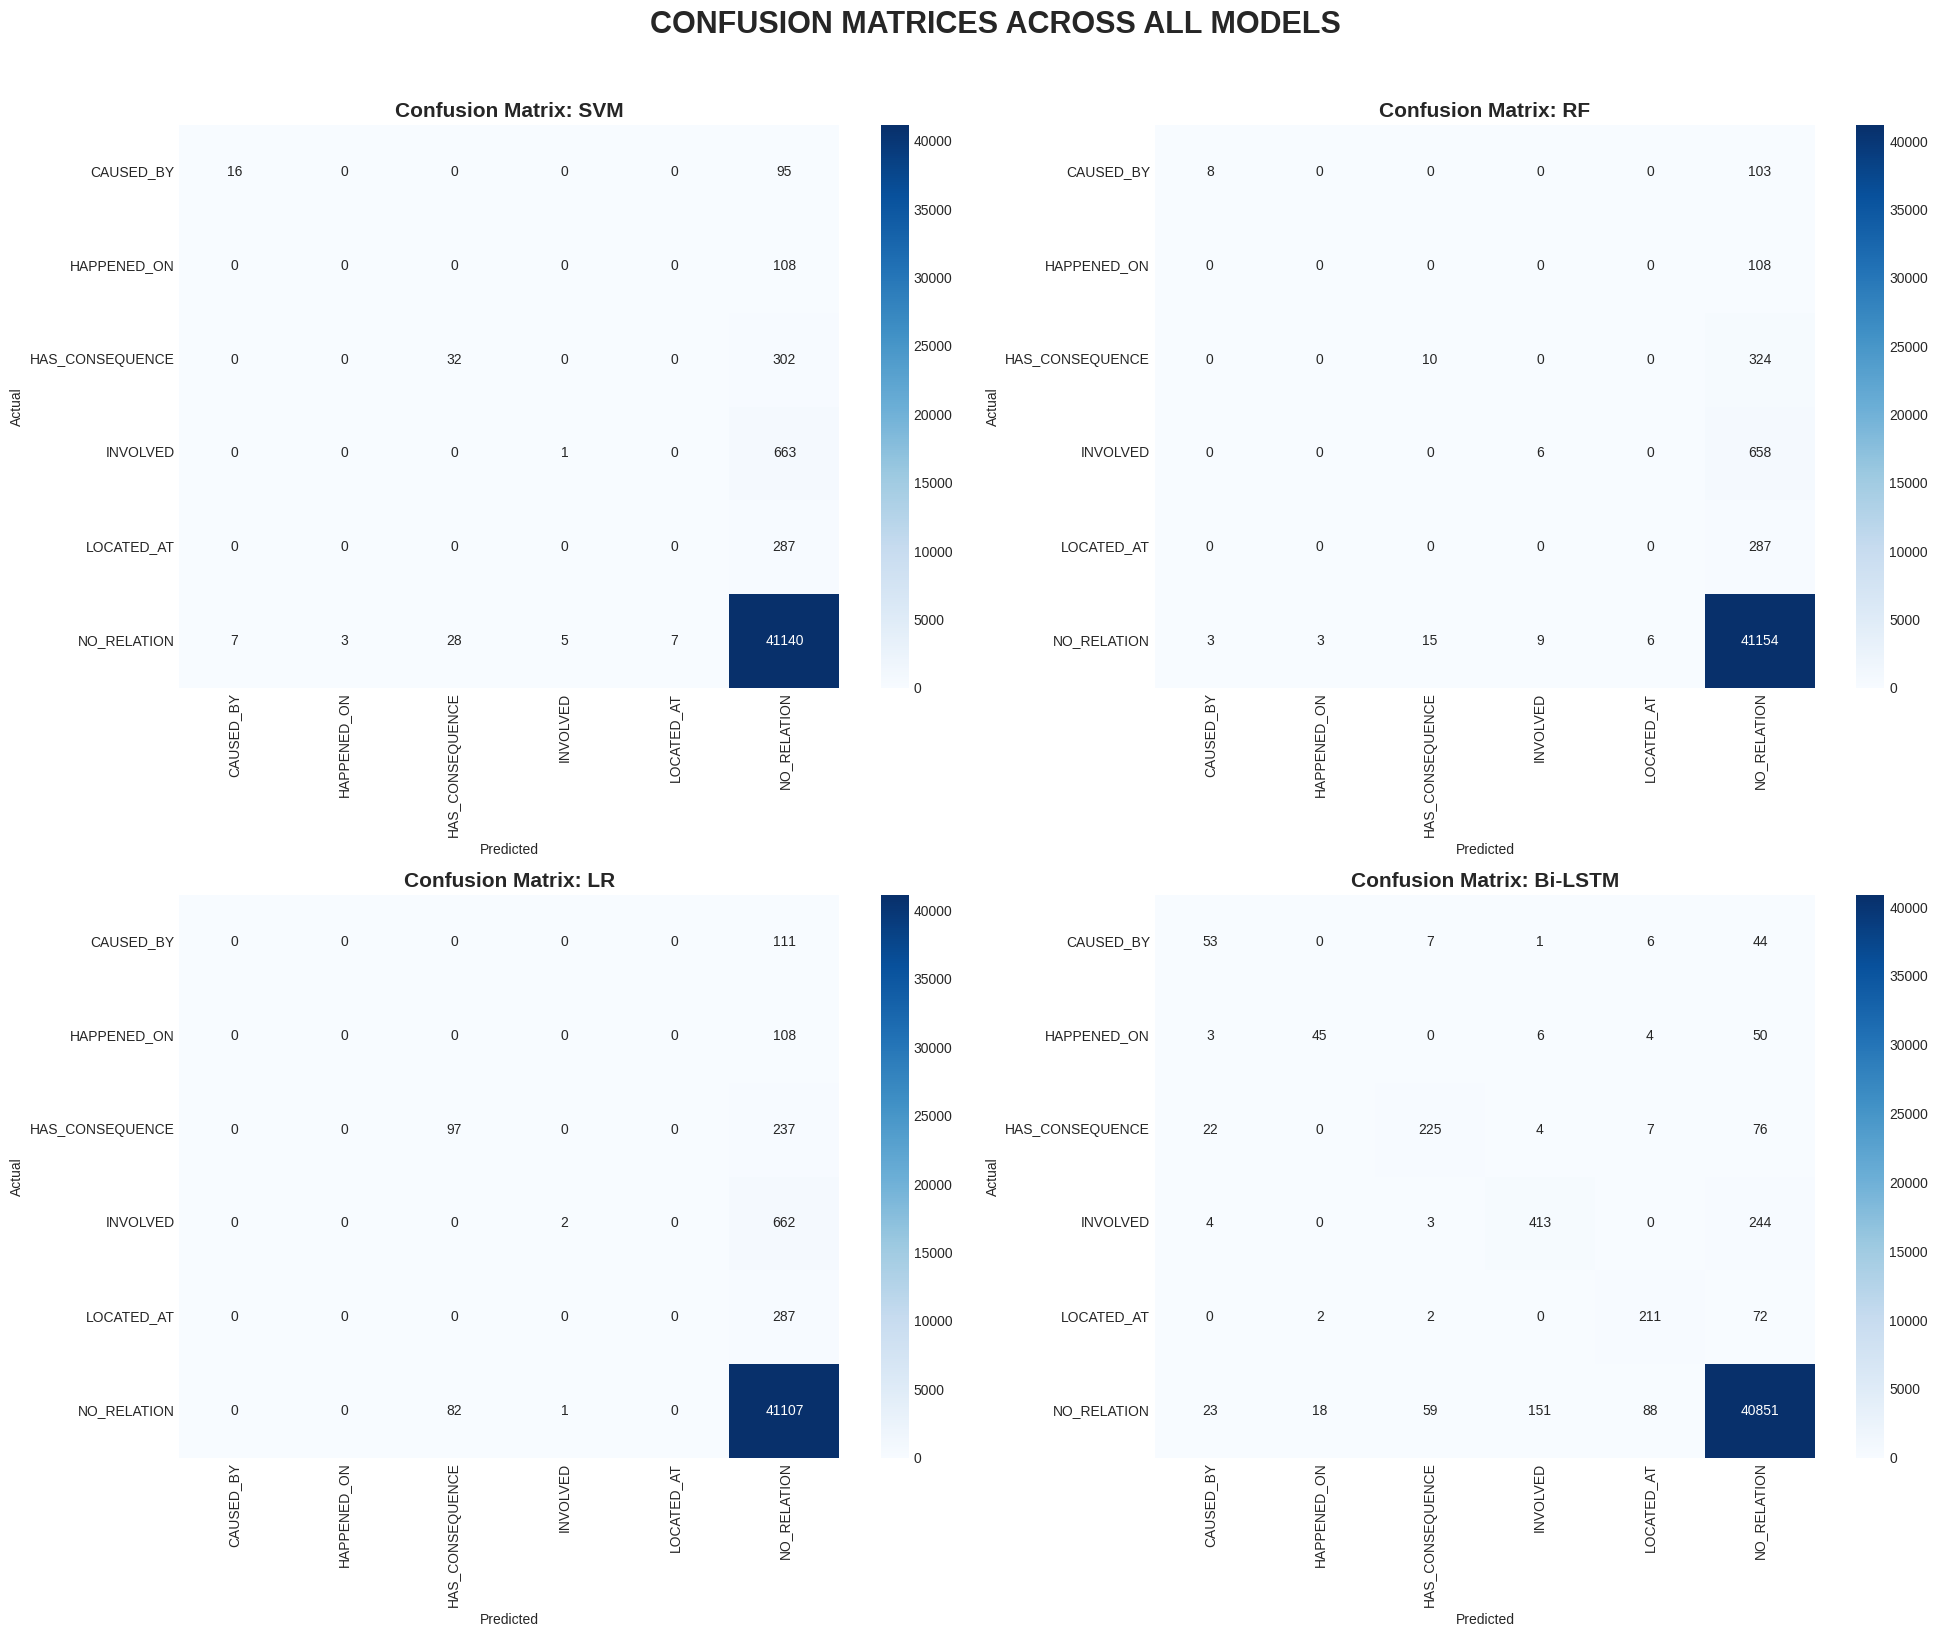

In [10]:
# Đánh giá
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, 
                             f1_score, recall_score, confusion_matrix)

results_list = []
all_predictions = {} 

# Chuẩn bị đặc trưng
X_test_ml = [
    {
        'types': f"{r.e1_type}_{r.e2_type}", 
        'context': " ".join(str(r.processed_text).split()), 
        'len': len(str(r.processed_text).split())
    } 
    for r in test_df.itertuples()
]

# Đánh giá mô hình ML
for name in ["SVM", "RF", "LR"]:
    model_path = os.path.join(MODEL_DIR, f"{name}.joblib")
    if os.path.exists(model_path):
        model = joblib.load(model_path)
        y_pred = model.predict(X_test_ml)
        all_predictions[name] = y_pred 
        
        results_list.append({
            "Model": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred, average='weighted'),
            "F1-Macro": f1_score(y_test, y_pred, average='macro'),
            "F1-Micro": f1_score(y_test, y_pred, average='micro')
        })

# Đánh giá mô hình Deep Learning
best_lstm_path = os.path.join(MODEL_DIR, "best_bilstm.pth")
if os.path.exists(best_lstm_path):
    lstm_eval_model = BiLSTM(len(vocab), len(label2id)).to(device)
    lstm_eval_model.load_state_dict(torch.load(best_lstm_path, map_location=device))
    lstm_eval_model.eval()
    
    test_loader = DataLoader(
        LSTMDataset(test_df['processed_text'].values, y_test, vocab), 
        batch_size=128, shuffle=False, pin_memory=True
    )
    
    lstm_preds = []
    with torch.inference_mode():
        for x, _ in test_loader:
            outputs = lstm_eval_model(x.to(device, non_blocking=True))
            lstm_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
    
    del lstm_eval_model
    torch.cuda.empty_cache()
            
    all_predictions["Bi-LSTM"] = lstm_preds 
    results_list.append({
        "Model": "Bi-LSTM",
        "Accuracy": accuracy_score(y_test, lstm_preds),
        "Recall": recall_score(y_test, lstm_preds, average='weighted'),
        "F1-Macro": f1_score(y_test, lstm_preds, average='macro'),
        "F1-Micro": f1_score(y_test, lstm_preds, average='micro')
    })


eval_df = pd.DataFrame(results_list).set_index("Model")
print("="*120)
print(tabulate(eval_df, headers='keys', tablefmt='pretty', floatfmt=".4f"))

# Trực quan hóa
plt.style.use('seaborn-v0_8-whitegrid')
metrics = eval_df.columns
n_metrics = len(metrics)

# Biểu đồ tổng hợp
ax_main = eval_df.plot(kind='bar', figsize=(16, 8), rot=0, width=0.8, colormap='viridis')
plt.title("ALL EVALUATION METRICS COMPARISON", fontsize=16, fontweight='bold', pad=20)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.ylim(0, 1.2)
plt.legend(title="Metrics", bbox_to_anchor=(1.02, 1), loc='upper left')

for p in ax_main.patches:
    if p.get_height() > 0:
        ax_main.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=8, fontweight='bold')
plt.tight_layout()
plt.show()

# Biểu đồ riêng cho từng chỉ số
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12)) # Chỉnh lại thành 2x2 vì còn 4 chỉ số
axes = axes.flatten()
for i, metric in enumerate(metrics):
    sns.barplot(x=eval_df.index, y=eval_df[metric], ax=axes[i], palette='magma', hue=eval_df.index, legend=False)
    axes[i].set_title(f"Metric: {metric}", fontsize=14, fontweight='bold')
    axes[i].set_ylim(0, 1.15)
    axes[i].set_ylabel("Score")
    
    for p in axes[i].patches:
        if p.get_height() > 0:
            axes[i].annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center', xytext=(0, 7), textcoords='offset points', fontsize=10, fontweight='bold')
if n_metrics < len(axes):
    for j in range(n_metrics, len(axes)): axes[j].axis('off')

plt.tight_layout()
plt.show()

# Confusion Matrices
rel_labels = list(label2id.keys())
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for i, (name, y_pred) in enumerate(all_predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=rel_labels, yticklabels=rel_labels)
    axes[i].set_title(f"Confusion Matrix: {name}", fontsize=15, fontweight='bold')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.suptitle("CONFUSION MATRICES ACROSS ALL MODELS", fontsize=22, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()